# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn
from itertools import product

In [39]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    step = 100
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')

        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

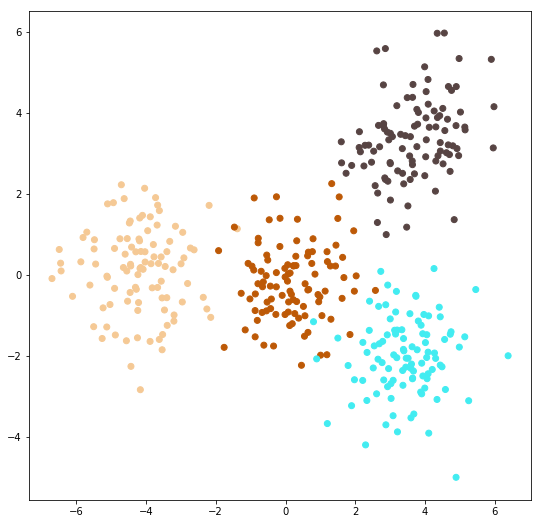

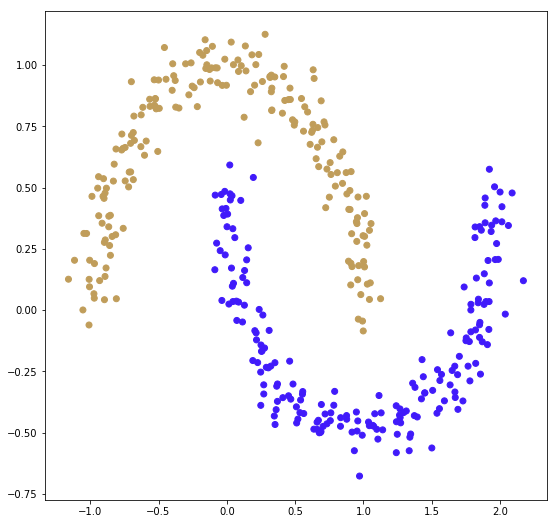

In [40]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [84]:
class KMeans:
    def __init__(self, n_clusters: int, init: str = "random",
                 max_iter: int = 300):
        """

        Parameters
        ----------
        n_clusters : int
            Число итоговых кластеров при кластеризации.
        init : str
            Способ инициализации кластеров. Один из трех вариантов:
            1. random --- центроиды кластеров являются случайными точками,
            2. sample --- центроиды кластеров выбираются случайно из  X,
            3. k-means++ --- центроиды кластеров инициализируются
                при помощи метода K-means++.
        max_iter : int
            Максимальное число итераций для kmeans.

        """
        self.n = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.centroids = None

    def _min_distances(self, X, centroids):
        """
        :param X:
        :param centroids:
        :return: np.array of indices of the closest centroids for each entry in X
        """
        distance_mtx = [0] * len(centroids)
        for i in range(len(centroids)):
            vector = centroids[i].reshape((1, centroids[i].shape[0]))
            distance_mtx[i] = np.linalg.norm(X - vector, axis=1)
        return np.argmin(distance_mtx, axis=0)


    def fit(self, X: np.ndarray, y=None) -> NoReturn:
        """
        Ищет и запоминает в self.centroids центроиды кластеров для X.

        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit обязаны принимать
            параметры X и y, даже если y не используется).

        """
        if self.init == "kmeans++":
            self.centroids = [X[np.random.randint(0, len(X))]]

            distances = [0] * len(X)
            for _ in range(self.n - 1):
                for k in range(len(X)):
                    point = X[k]
                    dist = np.inf
                    for i in range(len(self.centroids)):
                        center = self.centroids[i]
                        if np.linalg.norm(point - center) < dist:
                            dist = np.linalg.norm(point - center)
                    distances[k] = dist
                distances = np.cumsum(np.square(distances))
                rand = (0 - distances[-1]) * np.random.random_sample() + distances[-1]
                self.centroids.append(X[np.searchsorted(distances, rand)])

        elif self.init == "random":
            maxs = np.amax(X, axis=0)
            mins = np.amin(X, axis=0)
            self.centroids = [[] for _ in range(self.n)]
            for i in range(self.n):
                centroid = [0] * len(maxs)
                for j in range(len(maxs)):
                    centroid[j] = (maxs[j] - mins[j]) * np.random.random_sample() + mins[j]
                self.centroids[i] = np.array(centroid)

        elif self.init == "sample":
            self.centroids = np.take(X, np.random.choice(len(X), size=self.n, replace=False), axis=0)

        clusters = [0] * len(X)
        for _ in range(self.max_iter):
            clusters_updated = self._min_distances(X, self.centroids)
            # if centroids haven't moved
            if np.all(clusters == clusters_updated):
                return

            for cluster in range(self.n):
                if not np.sum(clusters_updated == cluster):
                    # reinitialise empty cluster
                    self.centroids[cluster] = np.take(X, np.random.choice(len(X), size=1), axis=0)[0]
                else:
                    # move centroid
                    self.centroids[cluster] = np.mean(X[clusters_updated == cluster], axis=0)

            clusters = clusters_updated

        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Для каждого элемента из X возвращает номер кластера,
        к которому относится данный элемент.

        Parameters
        ----------
        X : np.array
            Набор данных, для элементов которого находятся ближайшие кластера.

        Return
        ------
        labels : np.array
            Вектор индексов ближайших кластеров
            (по одному индексу для каждого элемента из X).

        """
        return self._min_distances(X, self.centroids)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

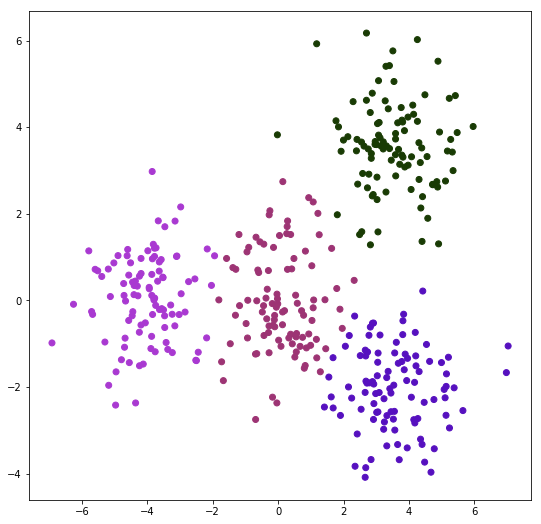

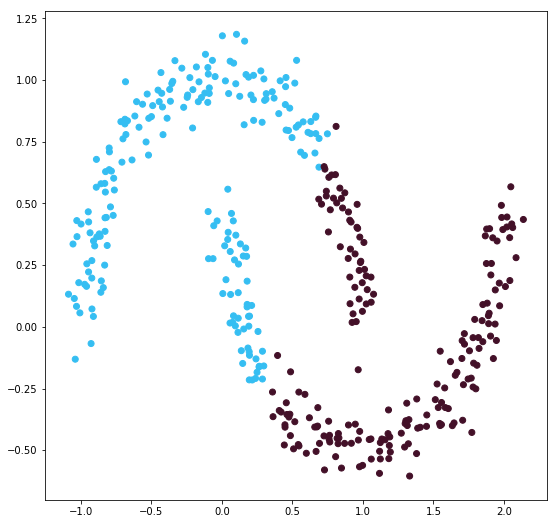

CPU times: user 480 ms, sys: 12.1 ms, total: 492 ms
Wall time: 492 ms


In [85]:
%%time
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2)
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [69]:
class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5,
                 leaf_size: int = 40, metric: str = "euclidean"):
        """

        Parameters
        ----------
        eps : float, min_samples : int
            Параметры для определения core samples.
            Core samples --- элементы, у которых в eps-окрестности есть
            хотя бы min_samples других точек.
        metric : str
            Метрика, используемая для вычисления расстояния между двумя точками.
            Один из трех вариантов:
            1. euclidean
            2. manhattan
            3. chebyshev
        leaf_size : int
            Минимальный размер листа для KDTree.

        """
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric

    def fit_predict(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соотв. кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        kdtree = KDTree(X, leaf_size=self.leaf_size, metric=self.metric)
        n = kdtree.query_radius(X, self.eps)
        label = [None] * len(X)
        c = -1
        for i in range(len(n)):
            if label[i] is not None:
                continue
            if len(n[i]) < self.min_samples:
                label[i] = -1
                continue
            q = deque(n[i])
            c += 1
            label[i] = c
            while q:
                point = q.popleft()
                if label[point] == -1:
                    label[point] = c
                if label[point] is not None:
                    continue
                label[point] = c
                if len(n[point]) >= self.min_samples:
                    q.extend(n[point])
                
        return label

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

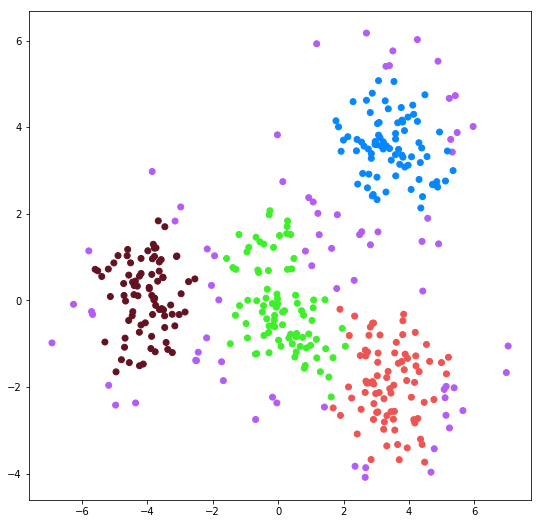

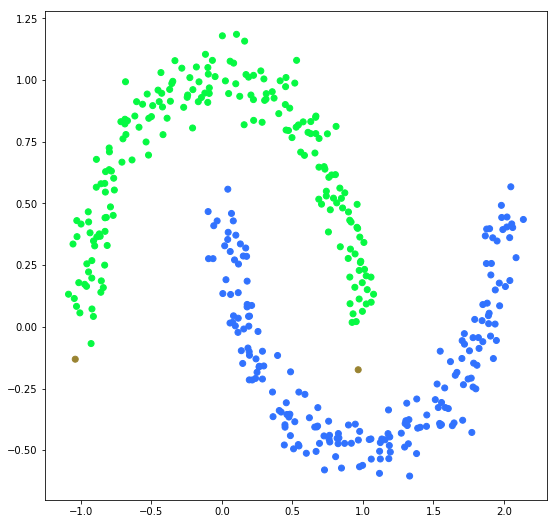

CPU times: user 498 ms, sys: 16.7 ms, total: 515 ms
Wall time: 515 ms


In [75]:
%%time
dbscan = DBScan(eps=0.70, min_samples=10)
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=0.15, min_samples=10)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [89]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """

        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n = n_clusters
        self.linkage = linkage

    def _get_dist(self, X, Y):
        D = np.sqrt(np.sum(X ** 2, axis=1) + np.sum(Y ** 2, axis=1, keepdims=True) - 2 * X @ Y.T)
        np.fill_diagonal(D, np.nan)
        return D
    
    def _min_indices(self, X):
        ind = np.nanargmin(X)
        return ind // X.shape[1], ind % X.shape[1]

    def fit_predict(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соответствующего кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        D = self._get_dist(X, X)
        clusters = np.arange(X.shape[0])
        
        if self.linkage == "average":
            # UPGMA ALGORITHM FOR AVERAGE LINKAGE
            # https://en.wikipedia.org/wiki/UPGMA
            
            for k in range(self.n, X.shape[0]):
                
                i, j = self._min_indices(D)
                # sizes of first and second clusters
                A = np.sum(clusters == clusters[i])
                B = np.sum(clusters == clusters[j])
                # joining clusters
                clusters[clusters == j] = clusters[i]
                
                for cluster in np.unique(clusters):
                    # skipping merged clusters
                    if cluster == clusters[i]:
                        continue
                    # getting indices for vectors in the cluster currently being updated
                    cur_cluster = np.where(clusters == cluster)[0]
                    
                    #updating average distances between the merged cluster and all points 
                    # in the current cluster
                    D[i, cur_cluster] = D[cur_cluster, i] = (A * D[i, cur_cluster] 
                                                             + B * D[j, cur_cluster]) / (A + B)
                # filling all distances for the recently merged cluster with nans
                D[j, :] = D[:, j] = np.nan

        
        labels = np.unique(clusters)
        for i in range(self.n):
            clusters[clusters == labels[i]] = i
        return clusters
        

In [90]:
X = np.array([[1, 2, 3], [0, 1, 1], [5, 6, 7], [4, 5, 4], [1, 1, 1], [5, 5, 5]])
agg_clustering = AgglomertiveClustering(n_clusters=2)
labels = agg_clustering.fit_predict(X)

/Users/dsashulya/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in sqrt


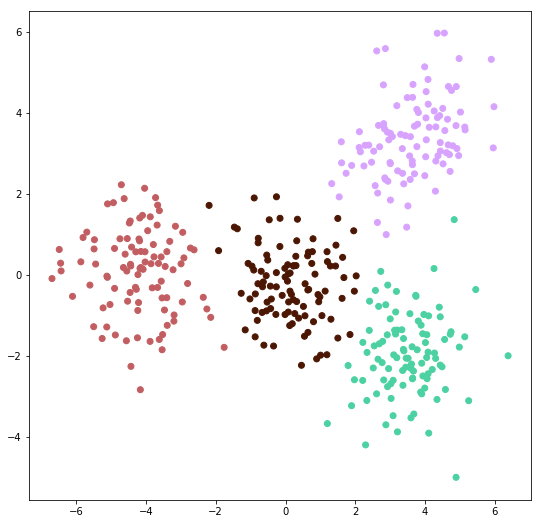

CPU times: user 2.32 s, sys: 59.6 ms, total: 2.38 s
Wall time: 2.1 s


In [91]:
%%time
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

In [10]:
class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):
        """

        Parameters
        ----------
        n_clusters : int
            Количество кластеров, которые необходимо найти (то есть, кластеры
            итеративно объединяются, пока их не станет n_clusters)
        linkage : str
            Способ для расчета расстояния между кластерами. Один из 3 вариантов:
            1. average --- среднее расстояние между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            2. single --- минимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
            3. complete --- максимальное из расстояний между всеми парами точек,
               где одна принадлежит первому кластеру, а другая - второму.
        """
        self.n = n_clusters
        self.linkage = linkage

    def _distance(self, x: np.ndarray, y: np.ndarray, linkage: str = "average"):
        """
        :param x: cluster
        :param y: cluster
        :param linkage: linkage type
        :return: distance between clusters
        """
        pairs = list(product(x, y))
        if linkage == "average":
            total = 0
            for pair in pairs:
                total += np.linalg.norm(pair[0] - pair[1])
            return total / len(pairs)

        elif linkage == "single":
            min_dist = np.inf
            for pair in pairs:
                norm = np.linalg.norm(pair[0] - pair[1])
                if norm < min_dist:
                    min_dist = norm
            return min_dist

        elif linkage == "complete":
            max_dist = -1
            for pair in pairs:
                norm = np.linalg.norm(pair[0] - pair[1])
                if norm > max_dist:
                    max_dist = norm
            return max_dist

    def _distance_matrix(self, X: np.ndarray, linkage: str = "average"):
        """
        :param X: np.ndarray of clusters
        :param linkage:
        :return: indices of clusters with minimum distance between them
        """
        mtx = [[-1] * len(X) for _ in range(len(X))]
        min_value = np.inf
        min_ind = None
        for i in range(len(X)):
            for j in range(len(X)):
                if i != j and mtx[i][j] == -1:
                    dist = self._distance(X[i], X[j], linkage=linkage)
                    mtx[i][j] = dist
                    mtx[j][i] = dist
                    if dist < min_value:
                        min_value = dist
                        min_ind = (i, j)
                elif i == j:
                    mtx[i][j] = 0
        return min_ind

    def fit_predict(self, X: np.ndarray, y=None) -> np.ndarray:
        """
        Кластеризует элементы из X,
        для каждого возвращает индекс соответствующего кластера.
        Parameters
        ----------
        X : np.array
            Набор данных, который необходимо кластеризовать.
        y : Ignored
            Не используемый параметр, аналогично sklearn
            (в sklearn считается, что все функции fit_predict обязаны принимать
            параметры X и y, даже если y не используется).
        Return
        ------
        labels : np.array
            Вектор индексов кластеров
            (Для каждой точки из X индекс соотв. кластера).

        """
        X_copy = X.copy()
        for k in reversed(range(self.n, len(X_copy))):
            min_ind = self._distance_matrix(X, self.linkage)
            i, j = min_ind
            merged = np.concatenate((np.reshape(X[i], (-1, 2)), np.reshape(X[j], (-1, 2))))
            X = [np.reshape(x, (-1, 2)) for l, x in enumerate(X) if l != i and l != j]
            X.append(merged)

        clusters = [0] * len(X_copy)
        # for cluster in clusters
        for k in range(len(X)):
            # for element in cluster
            for element in X[k]:
                # get index
                index = np.where(np.all(X_copy == element, axis=1))[0][0]
                clusters[index] = k
        return clusters

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

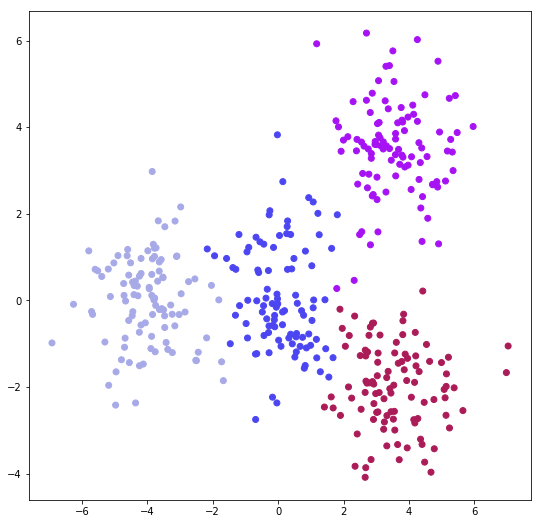

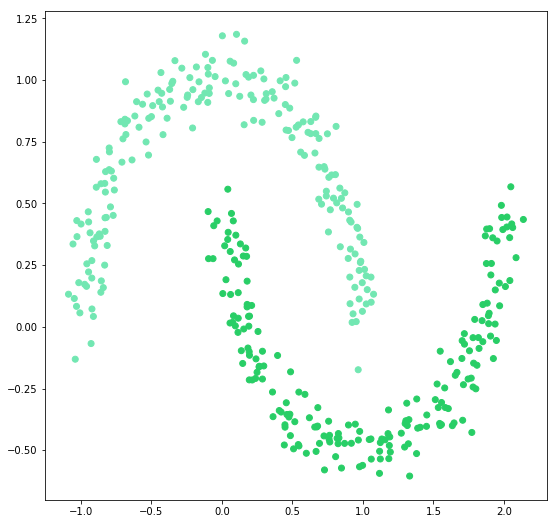

CPU times: user 8min 37s, sys: 3.63 s, total: 8min 40s
Wall time: 8min 45s


In [102]:
%%time
agg_clustering = AgglomertiveClustering(n_clusters=4)
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [42]:
def read_image(path: str) -> np.ndarray:
    """
    Читает изображение.

    Parameters
    ----------
    path : str
        Путь к изображению.
    
    Return
    ------
    image : np.array
        Трехмерный массив размера (N, M, C), 
        где N и M - размеры изображения, 
        а C - количество цветов (3 для обычного изображения).
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


def show_image(image: np.ndarray) -> NoReturn:
    """
    Выводит изображение

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    """
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.ndarray, path: str) -> NoReturn:
    """
    Сохраняет изображение.

    Parameters
    ----------
    image : np.array
        Трехмерный массив - нормализованное изображение в цветовой схеме RGB.
    path : str
        Путь для сохранения.
    """
    
    cv2.imwrite(path, cv2.cvtColor(cv2.normalize(image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX),\
                                   cv2.COLOR_RGB2BGR))

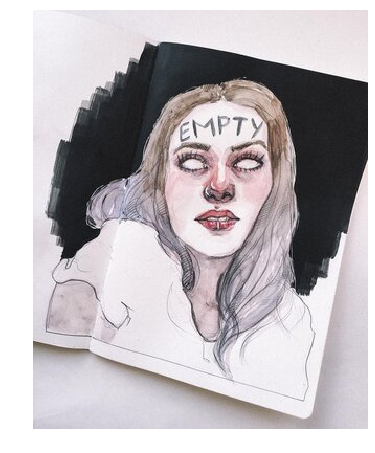

In [61]:
show_image(read_image("./image.jpg"))

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [112]:
def clusterize_image(image, n_clusters=5):
    img_flat = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_clusters, max_iter=15)
    kmeans.fit(img_flat)
    clusters = kmeans.predict(img_flat)

    colours = [0] * n_clusters
    for i in range(n_clusters):
        colours[i] = np.mean(img_flat[clusters == i], axis=0)
        img_flat[clusters == i] = colours[i]

    # def clusters_statistics(flatten_image, cluster_colors, cluster_labels)
    clusters_statistics(image.reshape((-1, 3)), np.array(colours), clusters) # Very slow (:
    return img_flat.reshape(image.shape)

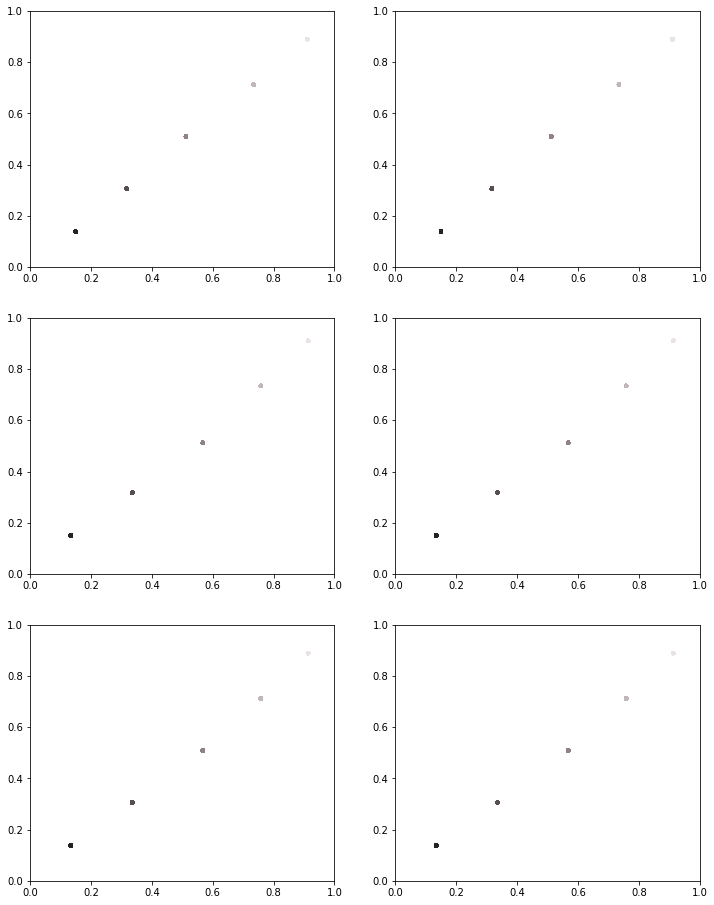

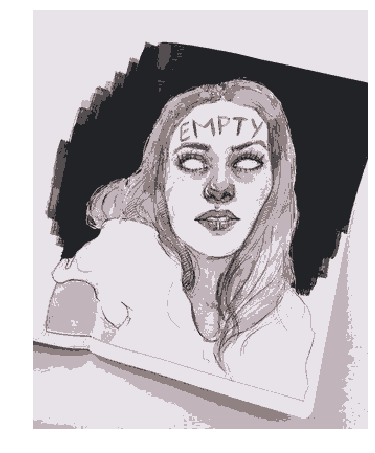

CPU times: user 19min 57s, sys: 21.5 s, total: 20min 19s
Wall time: 20min 34s


In [113]:
%%time
image = read_image("./image.jpg")
result = clusterize_image(image)
show_image(result)
save_image(result, "result.jpg")